# __Applying PCM to ARGO data in Mediterranean Sea__

The aim of this notebook is to be an example of applying the PCM method to in-situ T-S profiles. The dataset is a selection of Argo profiles localted in Mediterranean sea. Notebook developped and run in __local__

Libraries needed:

In [2]:
import xarray as xr
# xr.set_options(display_style='text')
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import argopy
# not at home
#argopy.set_options(cachedir='/home1/homedir5/perso/agarciaj/.cache/argopy',src='localftp',local_ftp='/home/ref-argo/gdac')
from argopy import DataFetcher as ArgoDataFetcher
#argopy.set_options(cachedir='/home1/homedir5/perso/agarciaj/.cache/argopy',src='localftp',local_ftp='/home/ref-argo/gdac')
argo_loader = ArgoDataFetcher()
#argo_loader = ArgoDataFetcher(cache=True)
# trying parallel-requests
#argo_loader = ArgoDataFetcher(src='erddap', parallel=True, chunks={'wmo': 2})

import pyxpcm
from pyxpcm.models import pcm

from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

## User input
***

__Argo data input__

In [3]:
spatial_extent = [-6, 35, 30, 46] # [lon max, lon min, lat max, lat min]
time_extent = ['2012', '2013']
depths_extent = [0, 1000]

__Model input__

In [4]:
# model features
z = np.arange(0.,-1000,-10.)
pcm_features = {'temperature': z}

# number of classes
K=6

# name of variables in dataset
var_name = 'TEMP'
features_in_ds = {'temperature': var_name}
features_zdim='PRES_INTERPOLATED'

## Getting data
***

We acces to data using argopy python library

In [5]:
# only one year
ds = argo_loader.region(spatial_extent + depths_extent + time_extent).to_xarray()
#ds

Some format ...

In [6]:
ds = ds.argo.point2profile()

# interpolation to standard levels
z = np.arange(0.,1000,10.)
ds = ds.argo.interp_std_levels(z)

# pressure should be negative
ds['PRES_INTERPOLATED'] = -np.abs(ds['PRES_INTERPOLATED'].values)
# depth attribute 'axis' for Plotter instance
ds.PRES_INTERPOLATED.attrs['axis'] = 'Z'

ds

<xarray.Dataset>
Dimensions:                (N_PROF: 502, PRES_INTERPOLATED: 100)
Coordinates:
    LONGITUDE              (N_PROF) float64 18.56 27.13 4.63 ... 6.708 -4.465
    LATITUDE               (N_PROF) float64 33.64 34.22 40.54 ... 42.99 35.91
  * N_PROF                 (N_PROF) int64 1244 1312 787 1153 ... 1311 2184 618
    TIME                   (N_PROF) datetime64[ns] 2012-01-01T12:12:30 ... 2012-12-31T21:25:36
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) float64 -0.0 -10.0 ... -990.0
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) float64 2.0 2.0 1.0 2.0 ... 1.0 2.0 3.0 1.0
    CYCLE_NUMBER           (N_PROF) float64 56.0 19.0 71.0 ... 129.0 14.0 28.0
    DATA_MODE              (N_PROF) object 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) float64 6.901e+06 6.901e+06 ... 6.9e+06
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 5.9 ... 990.0
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 38.169 ... 38.47753
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 18.004 ... 13.07569
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/10/14
    Fetched_constraints:  [x=-6.00/35.00; y=30.00/46.00; z=0.0/1000.0; t=2012...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

## Applying PCM
***

We create a model with K classes and temperature or salinity or both as features

### Create PCM

In [7]:
m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [8]:
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -2.651958

Save trained model

In [ ]:
# save model to development
# m.to_netcdf('models/Argo_Med_K6_temp.nc')

### Classify data

In [9]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [10]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [11]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name, outname=var_name + '_Q', keep_attrs=True, inplace=True);
#ds

Robustness

In [12]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:                (N_PROF: 502, PRES_INTERPOLATED: 100, pcm_class: 6, quantile: 3)
Coordinates:
  * pcm_class              (pcm_class) int64 0 1 2 3 4 5
    LONGITUDE              (N_PROF) float64 18.56 27.13 4.63 ... 6.708 -4.465
    LATITUDE               (N_PROF) float64 33.64 34.22 40.54 ... 42.99 35.91
  * N_PROF                 (N_PROF) int64 1244 1312 787 1153 ... 1311 2184 618
    TIME                   (N_PROF) datetime64[ns] 2012-01-01T12:12:30 ... 2012-12-31T21:25:36
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) float64 -0.0 -10.0 ... -990.0
  * quantile               (quantile) float64 0.05 0.5 0.95
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) float64 2.0 2.0 1.0 2.0 ... 1.0 2.0 3.0 1.0
    CYCLE_NUMBER           (N_PROF) float64 56.0 19.0 71.0 ... 129.0 14.0 28.0
    DATA_MODE              (N_PROF) object 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) float64 6.901e+06 6.901e+06 ... 6.9e+06
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 5.9 ... 990.0
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 38.169 ... 38.47753
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 18.004 ... 13.07569
    PCM_LABELS             (N_PROF) int64 5 0 1 0 1 0 5 5 0 ... 5 0 4 5 5 5 4 1
    PCM_POST               (pcm_class, N_PROF) float64 2.526e-09 ... 1.679e-34
    TEMP_Q                 (pcm_class, quantile, PRES_INTERPOLATED) float64 15.6 ... 13.96
    PCM_ROBUSTNESS         (N_PROF) float64 1.0 0.9815 1.0 0.91 ... 1.0 1.0 1.0
    PCM_ROBUSTNESS_CAT     (N_PROF) int64 4 3 4 3 4 2 3 5 4 ... 5 4 4 4 5 5 4 5
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           jovyan
    Fetched_date:         2020/10/14
    Fetched_constraints:  [x=-6.00/35.00; y=30.00/46.00; z=0.0/1000.0; t=2012...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

In [ ]:
# save dataset
# ds.to_netcdf('models/Argo_Med_K6_temp_ds.nc')

## Plot results
***

In [13]:
P = Plotter(ds, m)

#### __1. Vertical structure of classes__

Figure saved in figures/test.png


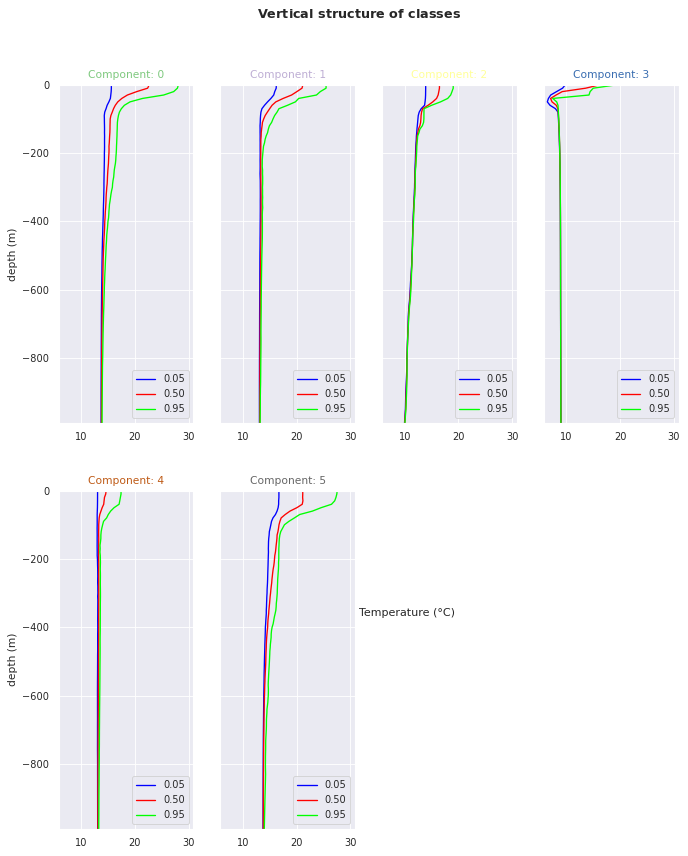

In [14]:
P.vertical_structure(q_variable = var_name + '_Q', sharey=True, xlabel='Temperature (°C)')
#P.save_BlueCloud('figures/vertical_struc_EX.png')
P.save_BlueCloud('figures/test.png')

Figure saved in figures/test.png


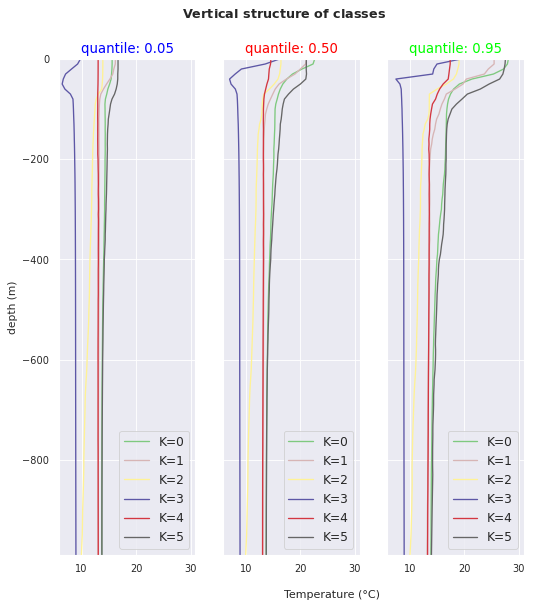

In [15]:
P.vertical_structure_comp(q_variable = var_name + '_Q', plot_q= 'all', xlabel='Temperature (°C)')
#P.save_BlueCloud('figures/vertical_struc_comp_EX.png')
P.save_BlueCloud('figures/test.png')

#### __2. Spatial distribution of classes__

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Figure saved in figures/test.png


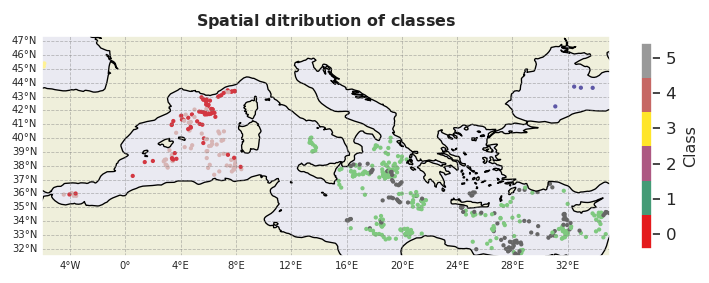

In [16]:
# Input should have only one time step
P.spatial_distribution()
#P.save_BlueCloud('figures/spatial_distr_EX.png')
P.save_BlueCloud('figures/test.png')

#### __3. Robustness__

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/con

Figure saved in figures/test_robustness.png


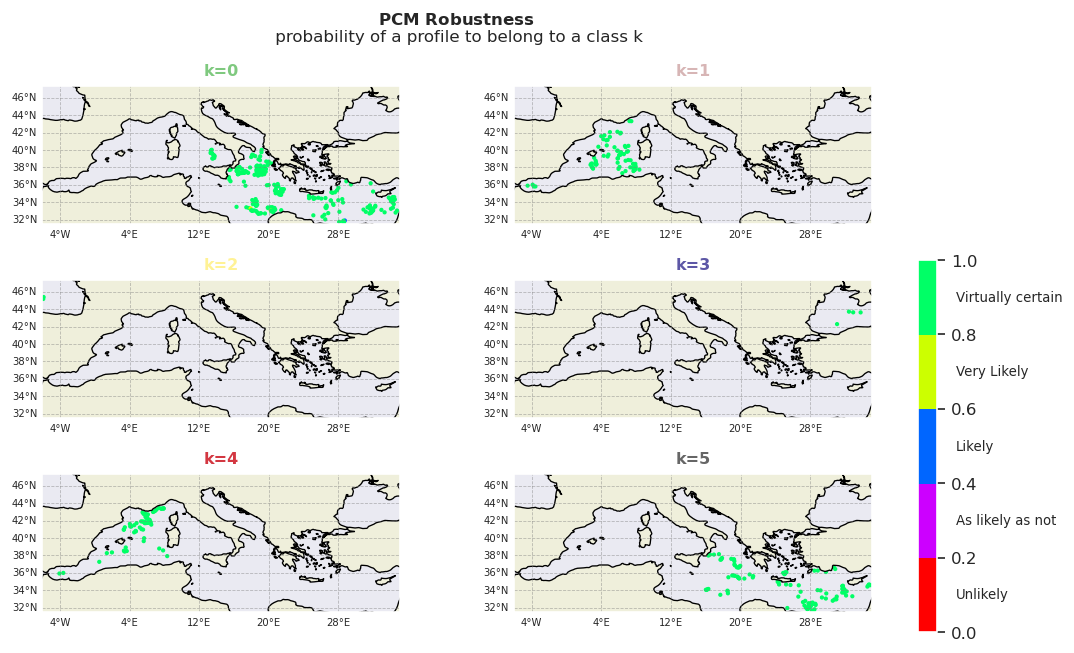

In [17]:
# Input should have only one time step
P.plot_robustness()
#P.save_BlueCloud('figures/robustness_EX.png')
P.save_BlueCloud('figures/test_robustness.png')

#### __4. Classes pie chart__

Figure saved in figures/test.png


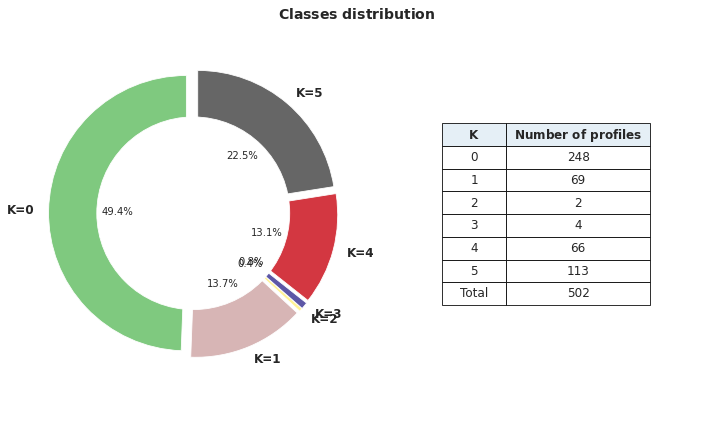

In [18]:
P.pie_classes()
#P.save_BlueCloud('figures/pie_chart_EX.png')
P.save_BlueCloud('figures/test.png')

#### __5. Temporal distribution__

Bar plot by __month__

Figure saved in figures/test.png


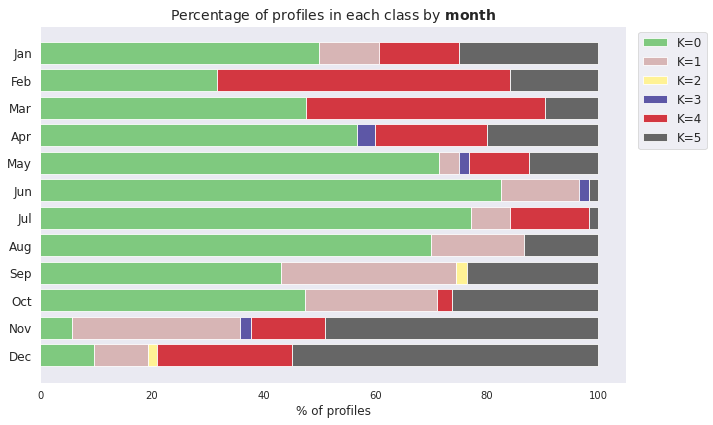

In [19]:
P.temporal_distribution(time_bins = 'month')
#P.save_BlueCloud('figures/temporal_distr_months_EX.png')
P.save_BlueCloud('figures/test.png')

Bar plot by __season__

Figure saved in figures/test.png


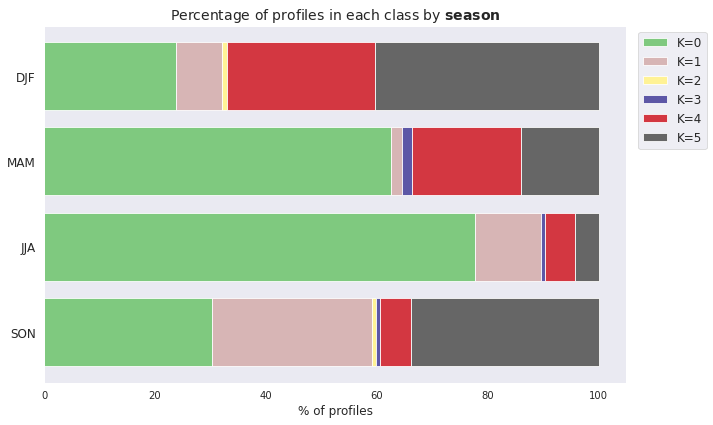

In [20]:
P.temporal_distribution(time_bins = 'season')
#P.save_BlueCloud('figures/temporal_distr_season_EX.png')
P.save_BlueCloud('figures/test.png')